In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import HTML
import pandas as pd

This notebook is my baseline attempt for constructing a working CNN using the MNIST Dataset through the PyTorch framework. After research and consultation with more proficient Kaggle users' notebooks (principally regarding the conversion of the foundational data medium from torchvision.datasets to pandas, and the subsequent submission to Kaggle that is common with all projects), I have opted to construct this using a basic CNN with Pooling, Dropout, etc. and the Adam optimizer.

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")

I would like to **thank** the following submission, https://www.kaggle.com/jcardenzana/mnist-pytorch-convolutional-neural-nets, for helping me transition the method through which I loaded the data to the Kaggle Digit Recognizer Dataset instead of PyTorch's respective dataset. I would also like to credit this notebook with helping me with the last cell in my own notebook (the construction of a pandas-made csv for submission purposes). 

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_digits(df):
    labels = []
    start_inx = 0
    if 'label' in df.columns:
        labels = [l for l in df.label.values]
        start_inx = 1
        
    
    digits = []
    for i in range(df.pixel0.size):
        digit = df.iloc[i].astype(float).values[start_inx:]
        digit = np.reshape(digit, (28,28))
        digit = transform(digit).type('torch.FloatTensor')
        if len(labels) > 0:
            digits.append([digit, labels[i]])
        else:
            digits.append(digit)

    return digits

trainX = get_digits(train)

  
batchSize  = 250 
validSize  = 0.2  


numTrain = len(trainX)
indices   = list(range(numTrain))
np.random.shuffle(indices)
split     = int(np.floor(validSize * numTrain))
trainIndex, validIndex = indices[split:], indices[:split]


from torch.utils.data.sampler import SubsetRandomSampler
trainSampler = SubsetRandomSampler(trainIndex)
validSampler = SubsetRandomSampler(validIndex)

trainLoad = torch.utils.data.DataLoader(trainX, batch_size=batchSize,
                    sampler=trainSampler)
validLoad = torch.utils.data.DataLoader(trainX, batch_size=batchSize, 
                    sampler=validSampler)

dataiter = iter(trainLoad)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([250, 1, 28, 28])
torch.Size([250])


The following cell contains the Convolutional Neural Network that I have constructed for the purposes of analyzing the MNIST Dataset.  I have done a lot of researching and (hopefully) learned the basics of a neural network and/or CNN. 

In [4]:
class myModel(nn.Module):
    
    def __init__(self):
        super(myModel, self).__init__()
        
        # The two Convolutional-Pooling Sets of Layers, 
        # connected through RELU functions.
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 30, kernel_size = 5, 
                      padding = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, 
                         stride = 3)
            )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(30, 60, kernel_size = 5, 
                      padding = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, 
                         stride = 3)
            )
        
        # Dropout 
        self.dropoutLayer = nn.Dropout()
        
        # Linear Layers
        self.linear1 = nn.Linear(4 * 4 * 60, 1000)
        self.linear2 = nn.Linear(1000, 500)
        self.linear3 = nn.Linear(500, 250)
        self.linear3 = nn.Linear(500, 10)
    
    def forward(self, x):
        
        # Feed-forward network function
        net = self.layer1(x)
        net = self.layer2(net)
        net = net.reshape(net.size(0), -1) 
        net = self.dropoutLayer(net)
        net = self.linear1(net)
        net = self.linear2(net)
        
        return net

In [5]:
CNN = myModel()
lossFunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN.parameters(), lr = 0.0001)
totalLosses = []

for epoch in range(1, 21):
    # Training for twenty epochs
    
    lossAtEpoch = 0.0
    
    for index, data in enumerate(trainLoad, start = 0):
        inputs, names = data
        optimizer.zero_grad() # Zero the parameter gradients
        
        outputs = CNN(inputs)
        loss = lossFunc(outputs, names)
        
        loss.backward() # Make loss into Tensor
        optimizer.step()
        
        lossAtEpoch += loss.item()
        
        batchSize2 = 134 # Miniature Batch Size
        
        if index % batchSize2 == (batchSize2 - 1):
            print("Loss (Epoch " + str(epoch) + ") : " + str(lossAtEpoch / batchSize2))
            totalLosses.append(lossAtEpoch / batchSize2)
            
            lossAtEpoch = 0.0

Loss (Epoch 1) : 6.235819228994313
Loss (Epoch 2) : 0.493605469144992
Loss (Epoch 3) : 0.2966913253958546
Loss (Epoch 4) : 0.21581824585350592
Loss (Epoch 5) : 0.17957135779199315
Loss (Epoch 6) : 0.15574164938793253
Loss (Epoch 7) : 0.1327580058975006
Loss (Epoch 8) : 0.12333206404278528
Loss (Epoch 9) : 0.11922526231675006
Loss (Epoch 10) : 0.1078158114105463
Loss (Epoch 11) : 0.10056343431403833
Loss (Epoch 12) : 0.09483209271817955
Loss (Epoch 13) : 0.0998260863403331
Loss (Epoch 14) : 0.09175936585820432
Loss (Epoch 15) : 0.08479333283907886
Loss (Epoch 16) : 0.08338828010957187
Loss (Epoch 17) : 0.08015453016190831
Loss (Epoch 18) : 0.07904491807097819
Loss (Epoch 19) : 0.07440952010063538
Loss (Epoch 20) : 0.0719083054547212


In [6]:
arrayOfLosses = np.array(totalLosses)
arrayOfLosses.shape # =(38,0)
arrayOfLosses = arrayOfLosses.reshape(2,10)

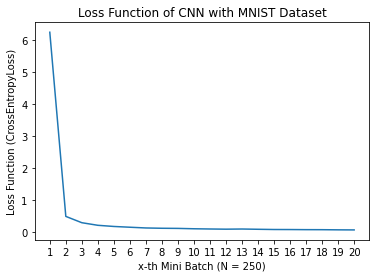

In [7]:
plt.plot(totalLosses)
plt.title("Loss Function of CNN with MNIST Dataset")
plt.ylabel("Loss Function (CrossEntropyLoss)")
plt.xlabel("x-th Mini Batch (N = 250)")
plt.xticks(np.arange(len(totalLosses)), np.arange(1, len(totalLosses)+1))
plt.show()

In [8]:
df = pd.DataFrame({"CNN Loss (Optim = Adam)": totalLosses})
HTML(df.to_html(index = False, classes = "dataframe"))

CNN Loss (Optim = Adam)
6.235819
0.493605
0.296691
0.215818
0.179571
0.155742
0.132758
0.123332
0.119225
0.107816


The below cell provides a rough accuracy of the model, though the true accuracy can be evaluated from the actual Kaggle score.

In [9]:
numCorrect = [0. for i in range(10)]
numTotal = [0. for i in range(10)]

with torch.no_grad():
    for data in trainLoad:
        
        images, labels = data
        outputs = CNN(images)
        
        _, predicted = torch.max(outputs, 1)
        
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            numCorrect[label] += c[i].item()
            numTotal[label] += 1

# Average accuracy
avg = 0

for i in range(10):
    avg += 100 * numCorrect[i] / numTotal[i]
    print('Accuracy of %5s : %2d %%' % (
        i + 1, 100 * numCorrect[i] / numTotal[i]))

print("Average Accuracy: " + str(avg / 10))

Accuracy of     1 : 97 %
Accuracy of     2 : 100 %
Accuracy of     3 : 95 %
Accuracy of     4 : 92 %
Accuracy of     5 : 98 %
Accuracy of     6 : 100 %
Accuracy of     7 : 96 %
Accuracy of     8 : 100 %
Accuracy of     9 : 97 %
Accuracy of    10 : 94 %
Average Accuracy: 97.32807392745282


In [10]:
# Define the test data loader
test        = pd.read_csv("../input/digit-recognizer/test.csv")
testX      = get_digits(test)
testLoad = torch.utils.data.DataLoader(testX, batch_size=batchSize)

In [11]:
ImageId = []
Label = []

# Loop through the data and get the predictions
for data in testLoad:
    # Move tensors to GPU if CUDA is available
    data = data.to(device)
    # Make the predictions
    output = CNN(data)
    # Get the most likely predicted digit
    _, pred = torch.max(output, 1)
    
    for i in range(len(pred)):        
        ImageId.append(len(ImageId)+1)
        Label.append(pred[i].cpu().numpy())

sub = pd.DataFrame(data={'ImageId':ImageId, 'Label':Label})
sub.describe
sub.to_csv("submission.csv", index = False)